In [1]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
import cv2
import os
import numpy as np
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from keras import losses
from keras import backend as K
import pandas as pd

In [2]:
print(os.getcwd())
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    a=(data - mu) / sigma
    a[np.isnan(a)] = 0 
    return a
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
 
def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

d:\360\output


In [3]:
filename=os.listdir("./zkx/txt/rgb/")
print(type(filename[0][0]))
print(filename)
for i in filename:
    print(i[0:-4])

<class 'str'>
['0.png', '1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png

In [4]:
class generator(keras.utils.Sequence):
    def __init__(self, image_filenames, batch_size):
        self.image_filenames = image_filenames
        self.batch_size = batch_size
    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    def __getitem__(self,idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        train=[]
        labels=[]
        for i in batch_x:
            img=cv2.imread("./zkx/txt/rgb/"+i,-1)
            img=cv2.cvtColor(img,cv2.COLOR_RGBA2BGR)
            img=cv2.resize(img,(160,160))
            img=img/255
            train.append(img)
            n=0
            label=[]
            while(n<4):
                img1=cv2.imread("./zkx/txt/label/"+i[0:-4]+"_"+str(n)+".png",-1)
                img1=cv2.resize(img1,(160,160))
                #print(img1.shape)
                img1=cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
                img1=img1/255
                label.append(img1)
                n=n+1
            label=np.array(label)
            label=label.reshape(160,160,4)
            labels.append(label)
        train=np.array(train)
        labels=np.array(labels)
        return train,labels

In [5]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
 
def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

In [6]:
def my_mean_squared_error(y_true, y_pred):
    y=K.mean(K.square(y_pred - y_true))
    return y


In [7]:
input_size_1 = 160
input_size_2 = 160
inpt = Input(shape=(input_size_1, input_size_2, 1))
conv1 = Conv2d_BN(inpt, 8, (3, 3))
conv1 = Conv2d_BN(conv1, 8, (3, 3))
pool1 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv1)
 
conv2 = Conv2d_BN(pool1, 16, (3, 3))
conv2 = Conv2d_BN(conv2, 16, (3, 3))
pool2 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv2)
 
conv3 = Conv2d_BN(pool2, 32, (3, 3))
conv3 = Conv2d_BN(conv3, 32, (3, 3))
pool3 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv3)
 
conv4 = Conv2d_BN(pool3, 64, (3, 3))
conv4 = Conv2d_BN(conv4, 64, (3, 3))
pool4 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv4)
 
conv5 = Conv2d_BN(pool4, 128, (3, 3))
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2d_BN(conv5, 128, (3, 3))
conv5 = Dropout(0.5)(conv5)
 
convt1 = Conv2dT_BN(conv5, 64, (3, 3))
concat1 = concatenate([conv4, convt1], axis=3)
concat1 = Dropout(0.5)(concat1)
conv6 = Conv2d_BN(concat1, 64, (3, 3))
conv6 = Conv2d_BN(conv6, 64, (3, 3))
 
convt2 = Conv2dT_BN(conv6, 32, (3, 3))
concat2 = concatenate([conv3, convt2], axis=3)
concat2 = Dropout(0.5)(concat2)
conv7 = Conv2d_BN(concat2, 32, (3, 3))
conv7 = Conv2d_BN(conv7, 32, (3, 3))
 
convt3 = Conv2dT_BN(conv7, 16, (3, 3))
concat3 = concatenate([conv2, convt3], axis=3)
concat3 = Dropout(0.5)(concat3)
conv8 = Conv2d_BN(concat3, 16, (3, 3))
conv8 = Conv2d_BN(conv8, 16, (3, 3))
 
convt4 = Conv2dT_BN(conv8, 8, (3, 3))
concat4 = concatenate([conv1, convt4], axis=3)
concat4 = Dropout(0.5)(concat4)
conv9 = Conv2d_BN(concat4, 8, (3, 3))
conv9 = Conv2d_BN(conv9, 8, (3, 3))
conv9 = Dropout(0.5)(conv9)
outpt = Conv2D(filters=4, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(conv9)
 
model = Model(inpt, outpt)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 160, 160, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
model=Sequential()
model.add(keras.applications.ResNet50(include_top=False,weights=None,input_shape=(160,160,1)))
# model.add(keras.layers.UpSampling2D(size = (32, 32), interpolation = "bilinear",name = "upsamping_6"))
model.add(keras.layers.Conv2DTranspose(filters = 1024,kernel_size = (3, 3),strides = (2, 2),padding = "same",kernel_initializer = "he_uniform",name = "Conv2DTranspose_1"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.05))
model.add(keras.layers.Conv2DTranspose(filters = 512,kernel_size = (3, 3),strides = (2, 2),padding = "same",kernel_initializer = "he_uniform",name = "Conv2DTranspose_2"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.05))
model.add(keras.layers.Conv2DTranspose(filters = 256,kernel_size = (3, 3),strides = (2, 2),padding = "same",kernel_initializer = "he_uniform",name = "Conv2DTranspose_4"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.05))
model.add(keras.layers.Conv2DTranspose(filters = 128,kernel_size = (3, 3),strides = (4, 4),padding = "same",kernel_initializer = "he_uniform",name = "Conv2DTranspose_5"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.02))
model.add(Conv2D(4, kernel_size = (1, 1), activation = "sigmoid",padding = "same", name = "conv_1"))
model.compile(optimizer = "adam",loss = "mean_squared_error",metrics = ["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23581440  
_________________________________________________________________
Conv2DTranspose_1 (Conv2DTra (None, 10, 10, 1024)      18875392  
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 1024)      4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10, 10, 1024)      0         
_________________________________________________________________
Conv2DTranspose_2 (Conv2DTra (None, 20, 20, 512)       4719104   
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 512)       2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 20, 512)       0

In [8]:
train=[]
test=[]
n=0
for i in filename:
    if(n%10!=0):
        train.append(i)
    else:
        test.append(i)
    n=n+1
print(len(train))
print(len(test))
train_load=generator(train,1)
test_load=generator(test,1)

637
71


In [9]:
x=model.layers[0].input_shape
print(x)

[(None, 160, 160, 1)]


In [12]:
filepath = "./zkx/txt/best_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(train_load,epochs = 200, shuffle=True,verbose = 1,validation_data=test_load,callbacks = callbacks_list)
model.save("./zkx/txt/final.h5")

Epoch 1/200


NotFoundError:  No algorithm worked!
	 [[node model/conv2d/Conv2D (defined at <ipython-input-11-a27b8226c42b>:10) ]] [Op:__inference_train_function_5485]

Function call stack:
train_function


In [26]:
#model = load_model('best_weights.h5',custom_objects={'loss': my_mean_squared_error})
model = load_model('./project/final_3.h5',compile=False)
model.compile(optimizer='adam',loss='mean_squared_error')

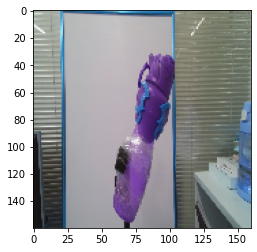

In [13]:
test=[]
img=cv2.imread("./project/rgb/color0.png")
#img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img=cv2.resize(img,(160,160))
img=img/255
plt.imshow(img)
plt.show()
test.append(img)

In [14]:
test=np.array(test)
#test=np.expand_dims(test,axis=3)
print(test.shape)
img1=model.predict(test)
print(img1.shape)

(1, 160, 160, 3)
(1, 160, 160, 4)


In [15]:
img1=np.squeeze(img1)
img1=img1.reshape(4,160,160)

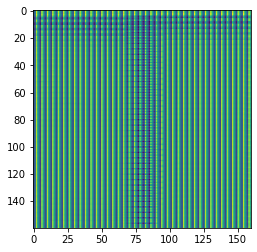

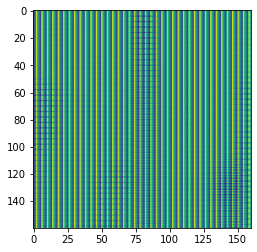

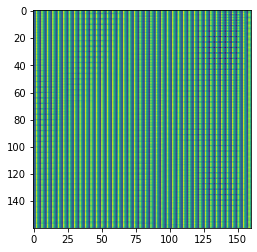

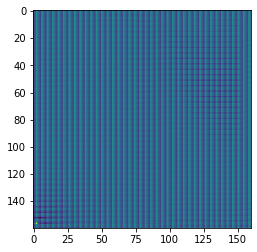

In [16]:
plt.imshow(img1[0])
plt.show()
plt.imshow(img1[1])
plt.show()
plt.imshow(img1[2])
plt.show()
plt.imshow(img1[3])
plt.show()

(1080, 1920, 3)
(1080, 1920)


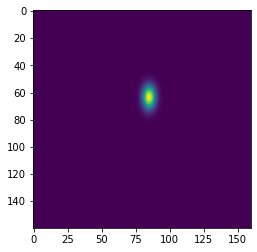

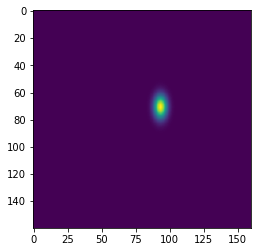

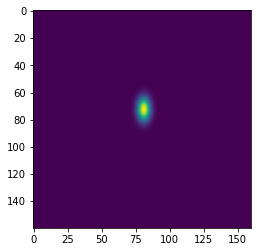

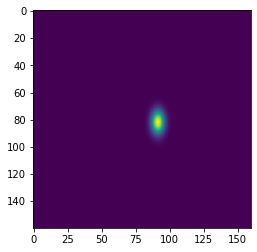

In [37]:
test1=[]
img=cv2.imread("./project/label/0_0.png",-1)
print(img.shape)
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
print(img.shape)
img=cv2.resize(img,(160,160))
img=img/255
test1.append(img)
plt.imshow(img)
plt.show()
img=cv2.imread("./project/label/0_1.png")
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img=cv2.resize(img,(160,160))
img=img/255
test1.append(img)
plt.imshow(img)
plt.show()
img=cv2.imread("./project/label/0_2.png")
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img=cv2.resize(img,(160,160))
img=img/255
test1.append(img)
plt.imshow(img)
plt.show()
img=cv2.imread("./project/label/0_3.png")
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img=cv2.resize(img,(160,160))
img=img/255
test1.append(img)
plt.imshow(img)
plt.show()

In [22]:
test1=np.array(test1)
print(test1.shape)
test1=test1.reshape(160,160,4)
print(test1.shape)

(4, 160, 160)
(160, 160, 4)


In [27]:
x=my_mean_squared_error(test1,test1+test1)
print(x)
print(x.shape)

tf.Tensor(0.007625508818723568, shape=(), dtype=float64)
()


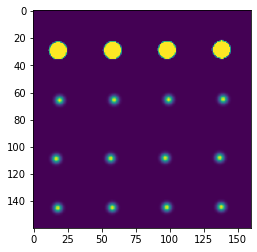

In [10]:
plt.imshow(x)
plt.show()

In [11]:
x=np.mean(test1,axis=0)
print(x.shape)

(160, 4)


In [12]:
x=np.mean(x,axis=0)
print(x.shape)

(4,)
